In [7]:
import os
from datetime import datetime
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12 or int(torch.__version__.split(".")[0]) == 2, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

import os
import shutil
import random
import matplotlib.pyplot as plt
import torch
import torchvision
from torch import nn
from torchvision import transforms
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

torch version: 2.4.1+cpu
torchvision version: 0.19.1+cpu


In [ ]:
# timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
# output_dir = f"./vit_outputs/exp_{timestamp}"
# os.makedirs(f"./vit_outputs/exp_{timestamp}", exist_ok=True)
# os.makedirs(f"./vit_outputs/exp_{timestamp}/models", exist_ok=True)
# os.makedirs(f"./vit_outputs/exp_{timestamp}/plots", exist_ok=True)

device = "cuda" if torch.cuda.is_available() else "cpu"
device

In [ ]:
# Split the data into training, validation and datasets
import splitfolders
import os

path = '/leonardo/home/userexternal/anagi000/orig_dataset/skin_disease_data_crops' #'D:\VSCode_Projects\Thesis_Project\Crops_Fair_Skin_Train'
print(os.listdir(path))


splitfolders.ratio(path, output="/leonardo/home/userexternal/anagi000/Project/swin_transformer/training_data_split", seed=1337, ratio=(.6, .2, .2))


#splitfolders.ratio(path, output="D:\VSCode_Projects\Thesis_Project\Crops_Fair_Skin_Train_1000/mix_data_split", seed=1337, ratio=(.6, .2, .2))

In [ ]:
# Setup directory paths to train and test images
train_dir = r"/leonardo/home/userexternal/anagi000/Project/swin_transformer/training_data_split/train"
test_dir = r"/leonardo/home/userexternal/anagi000/Project/swin_transformer/training_data_split/val"

In [ ]:
from pathlib import Path
destination_folder="/leonardo/home/userexternal/anagi000/orig_dataset/skin_disease_data_crops"
base_folder = Path(destination_folder)

for subfolder in base_folder.iterdir():
    if subfolder.is_dir():
        file_count = sum(1 for f in subfolder.iterdir() if f.is_file())
        print(f"{subfolder.name}: {file_count} files")


# Split the data into training, validation and datasets
# import splitfolders
# import os

# path = destination_folder
# print(os.listdir(path))
# splitfolders.ratio(path, output="./mix_data_split_Skin_Disease_Training_Data_Random_Sampling_from_scratch_exp_3_classes", seed=435, ratio=(.6, .2, .2))


import os

# Path to your main dataset folder
main_folder = '/leonardo/home/userexternal/anagi000/Project/swin_transformer/training_data_split'  # <-- change this

# Subfolders
splits = ['train', 'test', 'val']

# Dictionary to hold the results
summary = {}

for split in splits:
    split_path = os.path.join(main_folder, split)
    total_files = 0
    summary[split] = {}
    
    # Check if the directory exists
    if not os.path.exists(split_path):
        print(f"Directory not found: {split_path}")
        continue

    for disease in os.listdir(split_path):
        disease_path = os.path.join(split_path, disease)
        
        if not os.path.isdir(disease_path):
            continue
        
        # Count files in disease folder
        num_files = len([
            f for f in os.listdir(disease_path)
            if os.path.isfile(os.path.join(disease_path, f))
        ])
        
        summary[split][disease] = num_files
        total_files += num_files

    print(f"\n{split.upper()} - Total files: {total_files}")
    for disease, count in summary[split].items():
        print(f"  {disease}: {count} files")


# Setup directory paths to train and test images
train_dir = r"/leonardo/home/userexternal/anagi000/Project/swin_transformer/training_data_split/train"
test_dir = r"/leonardo/home/userexternal/anagi000/Project/swin_transformer/training_data_split/val"


# Create image size (from Table 3 in the ViT paper)
IMG_SIZE = 224

# Create transform pipeline manually
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])
print(f"Manually created transforms: {manual_transforms}")

from going_modular import data_setup

# Set the batch size
BATCH_SIZE = 32 # this is lower than the ViT paper but it's because we're starting small

# Create data loaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms, # use manually created transforms
    batch_size=BATCH_SIZE
)

train_dataloader, test_dataloader, class_names


from going_modular import data_setup

# Set the batch size
BATCH_SIZE = 32 # this is lower than the ViT paper but it's because we're starting small

# Create data loaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms, # use manually created transforms
    batch_size=BATCH_SIZE
)

train_dataloader, test_dataloader, class_names


class_names


from going_modular.helper_functions import set_seeds
set_seeds()


# 1. Get pretrained weights for ViT-Base
# Get the pretrained weights for ViT-Base trained on ImageNet-1k from
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT # requires torchvision >= 0.13, "DEFAULT" means best available

# 2. Setup a ViT model instance with pretrained weights
pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)

# 3. Freeze the base parameters
#for parameter in pretrained_vit.parameters():
#    parameter.requires_grad = False

# 4. Change the classifier head (set the seeds to ensure same initialization with linear head)
#set_seeds()
pretrained_vit.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)
# pretrained_vit # uncomment for model output




from torchinfo import summary

# Print a summary using torchinfo (uncomment for actual output)
summary(model=pretrained_vit,
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)


#Original

from torchinfo import summary

# Print a summary using torchinfo (uncomment for actual output)
summary(model=pretrained_vit,
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

# Get automatic transforms from pretrained ViT weights
pretrained_vit_transforms = pretrained_vit_weights.transforms()
print(pretrained_vit_transforms)



# Setup dataloaders
train_dataloader_pretrained, test_dataloader_pretrained, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                                     test_dir=test_dir,
                                                                                                     transform=pretrained_vit_transforms,
                                                                                                     batch_size=32)

from going_modular import engine

# Create optimizer and loss function
#optimizer = torch.optim.Adam(params=pretrained_vit.parameters(),
#                             lr=1e-3)
optimizer = torch.optim.Adam(params=pretrained_vit.parameters(),
                             lr=1e-5)


loss_fn = torch.nn.CrossEntropyLoss()

# Train the classifier head of the pretrained ViT feature extractor model
#set_seeds()
pretrained_vit_results = engine.train(model=pretrained_vit,
                                      train_dataloader=train_dataloader_pretrained,
                                      test_dataloader=test_dataloader_pretrained,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=100,
                                      device=device)


# Plot the loss curves
from going_modular.helper_functions import plot_loss_curves

plot_loss_curves(pretrained_vit_results, save_path=output_dir+"/plots/loss_accuracy_curve.png")


# Save the model
from going_modular import utils

utils.save_model(model=pretrained_vit,
                 target_dir=output_dir+"/models",
                 model_name="Pretrained_vit__patches_sliding_window_algorithm_all_classes_scratch_training_mix_data_split_Skin_Disease_Training_Data_Random_Sampling.pth")


from torchinfo import summary
# Print a summary using torchinfo (uncomment for actual output)
summary(model=pretrained_vit,
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)


from pathlib import Path

# Get the model size in bytes then convert to megabytes
pretrained_vit_model_size = Path(output_dir+"/models/Pretrained_vit__patches_sliding_window_algorithm_all_classes_scratch_training_mix_data_split_Skin_Disease_Training_Data_Random_Sampling.pth").stat().st_size // (1024*1024) # division converts bytes to megabytes (roughly)
print(f"Pretrained ViT feature extractor model size: {pretrained_vit_model_size} MB")

# CONFORMAL PREDICTION

In [2]:
import torch
from torchvision import models
from pathlib import Path

# Set the same device used during training
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
# # Split the data into training, validation and datasets
# import splitfolders
# import os

# path = '/leonardo/home/userexternal/anagi000/orig_dataset/skin_disease_data_crops' #'D:\VSCode_Projects\Thesis_Project\Crops_Fair_Skin_Train'
# print(os.listdir(path))


# splitfolders.ratio(path, output="/leonardo/home/userexternal/anagi000/Project/swin_transformer/training_data_split", seed=1337, ratio=(0.5, 0.5), 
#                    group_prefix=None)

In [1]:
# Split the data into training, validation and datasets
import splitfolders
import os

path = 'D:\VSCode_Projects\Thesis_Project\skin_disease_data' #'D:\VSCode_Projects\Thesis_Project\Crops_Fair_Skin_Train'
print(os.listdir(path))


splitfolders.ratio(path, output="./ViT_Batch_Job/training_data_split_Conformal_Prediction", seed=1337, ratio=(.6, .2, .2))

['crops_fair_skin_esantema-maculo-papuloso', 'crops_fair_skin_esantema-morbilliforme', 'crops_fair_skin_esantema-polimorfo-like', 'crops_fair_skin_esantema-virale', 'crops_fair_skin_esantema_iatrogeno_farmaco_indotta', 'crops_fair_skin_orticaria', 'crops_fair_skin_pediculosi', 'crops_fair_skin_scabbia', 'crops_fair_skin_varicella']


Copying files: 327362 files [35:09, 155.16 files/s]


In [ ]:
# # Split the data into training, validation and datasets
# import splitfolders
# import os

# path = 'D:\VSCode_Projects\Thesis_Project\skin_disease_data' #'D:\VSCode_Projects\Thesis_Project\Crops_Fair_Skin_Train'
# print(os.listdir(path))


# splitfolders.ratio(path, output="./ViT_Batch_Job/training_data_split_Conformal_Prediction", seed=1337, ratio=(0.5, 0.5), 
#                    group_prefix=None)

In [3]:
model_path = Path("D:/VSCode_Projects/Thesis_Project/Experiments/ViT_Experiment_9-7-2025") / "models" / "model_best_epoch_92_acc_0.9860.pth"

In [ ]:
# # Split the data into training, validation and datasets
# import splitfolders
# import os

# path = '/leonardo/home/userexternal/anagi000/orig_dataset/skin_disease_data_crops' #'D:\VSCode_Projects\Thesis_Project\Crops_Fair_Skin_Train'
# print(os.listdir(path))


# splitfolders.ratio(path, output="/leonardo/home/userexternal/anagi000/Project/swin_transformer/training_data_split", seed=1337, ratio=(0.5, 0.5), 
#                    group_prefix=None)


# import splitfolders

# # Path to the current test folder
# test_path = '/leonardo/home/userexternal/anagi000/Project/swin_transformer/training_data_split/test'

# # Split test into calibration (50%) and test (50%)
# splitfolders.ratio(
#     input=test_path,
#     output='/leonardo/home/userexternal/anagi000/Project/swin_transformer/test_split_for_conformal',
#     seed=2025,
#     ratio=(.5, .5),
#     group_prefix=None  # ensures it's by files, not grouped by name
# )


In [4]:
# Setup directory paths to train and test images
val_dir = r"./ViT_Batch_Job/training_data_split_Conformal_Prediction/val"
test_dir = r"./ViT_Batch_Job/training_data_split_Conformal_Prediction/test"

In [9]:
# from pathlib import Path
# destination_folder="/leonardo/home/userexternal/anagi000/orig_dataset/skin_disease_data_crops"
# base_folder = Path(destination_folder)

# for subfolder in base_folder.iterdir():
#     if subfolder.is_dir():
#         file_count = sum(1 for f in subfolder.iterdir() if f.is_file())
#         print(f"{subfolder.name}: {file_count} files")

# Split the data into training, validation and datasets
# import splitfolders
# import os
# path = destination_folder
# print(os.listdir(path))
# splitfolders.ratio(path, output="./mix_data_split_Skin_Disease_Training_Data_Random_Sampling_from_scratch_exp_3_classes", seed=435, ratio=(.6, .2, .2))


import os

# Path to your main dataset folder
main_folder = './ViT_Batch_Job/training_data_split_Conformal_Prediction'  # <-- change this

# Subfolders
splits = ['train', 'test', 'val']

# Dictionary to hold the results
summary = {}

for split in splits:
    split_path = os.path.join(main_folder, split)
    total_files = 0
    summary[split] = {}
    
    # Check if the directory exists
    if not os.path.exists(split_path):
        print(f"Directory not found: {split_path}")
        continue

    for disease in os.listdir(split_path):
        disease_path = os.path.join(split_path, disease)
        
        if not os.path.isdir(disease_path):
            continue
        
        # Count files in disease folder
        num_files = len([
            f for f in os.listdir(disease_path)
            if os.path.isfile(os.path.join(disease_path, f))
        ])
        
        summary[split][disease] = num_files
        total_files += num_files

    print(f"\n{split.upper()} - Total files: {total_files}")
    for disease, count in summary[split].items():
        print(f"  {disease}: {count} files")


# Setup directory paths to train and test images
# train_dir = r"/leonardo/home/userexternal/anagi000/Project/swin_transformer/training_data_split/train"
# test_dir = r"/leonardo/home/userexternal/anagi000/Project/swin_transformer/training_data_split/val"

val_dir = r"./ViT_Batch_Job/training_data_split_Conformal_Prediction/val"
test_dir = r"./ViT_Batch_Job/training_data_split_Conformal_Prediction/test"

# Create image size (from Table 3 in the ViT paper)
IMG_SIZE = 224

# Create transform pipeline manually
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])
print(f"Manually created transforms: {manual_transforms}")

from going_modular import data_setup

# Set the batch size
BATCH_SIZE = 32 # this is lower than the ViT paper but it's because we're starting small

# Create data loaders
val_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=val_dir,
    test_dir=test_dir,
    transform=manual_transforms, # use manually created transforms
    batch_size=BATCH_SIZE
)

val_dataloader, test_dataloader, class_names


from going_modular import data_setup

# Set the batch size
BATCH_SIZE = 32 # this is lower than the ViT paper but it's because we're starting small

# Create data loaders
val_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=val_dir,
    test_dir=test_dir,
    transform=manual_transforms, # use manually created transforms
    batch_size=BATCH_SIZE
)

val_dataloader, test_dataloader, class_names


class_names


from going_modular.helper_functions import set_seeds
set_seeds()



TRAIN - Total files: 196412
  crops_fair_skin_esantema-maculo-papuloso: 7005 files
  crops_fair_skin_esantema-morbilliforme: 3546 files
  crops_fair_skin_esantema-polimorfo-like: 7194 files
  crops_fair_skin_esantema-virale: 50746 files
  crops_fair_skin_esantema_iatrogeno_farmaco_indotta: 16510 files
  crops_fair_skin_orticaria: 80373 files
  crops_fair_skin_pediculosi: 5982 files
  crops_fair_skin_scabbia: 19430 files
  crops_fair_skin_varicella: 5626 files

TEST - Total files: 65481
  crops_fair_skin_esantema-maculo-papuloso: 2336 files
  crops_fair_skin_esantema-morbilliforme: 1182 files
  crops_fair_skin_esantema-polimorfo-like: 2399 files
  crops_fair_skin_esantema-virale: 16917 files
  crops_fair_skin_esantema_iatrogeno_farmaco_indotta: 5505 files
  crops_fair_skin_orticaria: 26792 files
  crops_fair_skin_pediculosi: 1995 files
  crops_fair_skin_scabbia: 6478 files
  crops_fair_skin_varicella: 1877 files

VAL - Total files: 65469
  crops_fair_skin_esantema-maculo-papuloso: 2335

In [10]:
# 1. Get pretrained weights for ViT-Base
# Get the pretrained weights for ViT-Base trained on ImageNet-1k from
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT # requires torchvision >= 0.13, "DEFAULT" means best available

# 2. Setup a ViT model instance with pretrained weights
pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)

# 3. Freeze the base parameters
#for parameter in pretrained_vit.parameters():
#    parameter.requires_grad = False

# 4. Change the classifier head (set the seeds to ensure same initialization with linear head)
#set_seeds()
pretrained_vit.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)
# pretrained_vit # uncomment for model output

In [11]:
import torch
from torchvision import models
from pathlib import Path

model_path = Path("D:/VSCode_Projects/Thesis_Project/Experiments/ViT_Experiment_9-7-2025") / "models" / "model_best_epoch_92_acc_0.9860.pth"
#model_path = Path(output_dir) / "models" / "Pretrained_vit__patches_sliding_window_algorithm_all_classes_scratch_training_mix_data_split_Skin_Disease_Training_Data_Random_Sampling.pth"

pretrained_vit.load_state_dict(torch.load(model_path, map_location=device))
pretrained_vit.eval()

C:\Users\alita\AppData\Local\Temp\ipykernel_10888\935966064.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_vit.load_state_dict(torch.load(model_path, map_loc

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [12]:
from torchinfo import summary

# Print a summary using torchinfo (uncomment for actual output)
summary(model=pretrained_vit,
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)


#Original

from torchinfo import summary

# Print a summary using torchinfo (uncomment for actual output)
summary(model=pretrained_vit,
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

# Get automatic transforms from pretrained ViT weights
pretrained_vit_transforms = pretrained_vit_weights.transforms()
print(pretrained_vit_transforms)



# Setup dataloaders
val_dataloader_pretrained, test_dataloader_pretrained, class_names = data_setup.create_dataloaders(train_dir=val_dir,
                                                                                                     test_dir=test_dir,
                                                                                                     transform=pretrained_vit_transforms,
                                                                                                     batch_size=32)

from going_modular import engine

# Create optimizer and loss function
#optimizer = torch.optim.Adam(params=pretrained_vit.parameters(),
#                             lr=1e-3)
optimizer = torch.optim.Adam(params=pretrained_vit.parameters(),
                             lr=1e-5)


loss_fn = torch.nn.CrossEntropyLoss()


ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


In [13]:
torch.manual_seed(42)
def eval_model(model: torch.nn.Module, 
               data_loader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               accuracy_fn):
    """Returns a dictionary containing the results of model predicting on data_loader.

    Args:
        model (torch.nn.Module): A PyTorch model capable of making predictions on data_loader.
        data_loader (torch.utils.data.DataLoader): The target dataset to predict on.
        loss_fn (torch.nn.Module): The loss function of model.
        accuracy_fn: An accuracy function to compare the models predictions to the truth labels.

    Returns:
        (dict): Results of model making predictions on data_loader.
    """
    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            # Make predictions with the model
            y_pred = model(X)
            
            # Accumulate the loss and accuracy values per batch
            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y_true=y, 
                                y_pred=y_pred.argmax(dim=1)) # For accuracy, need the prediction labels (logits -> pred_prob -> pred_labels)
        
        # Scale loss and acc to find the average loss/acc per batch
        loss /= len(data_loader)
        acc /= len(data_loader)
        
    return {"model_name": model.__class__.__name__, # only works when model was created with a class
            "model_loss": loss.item(),
            "model_acc": acc}



In [14]:
# Calculate model 0 results on test dataset
# model_0_results = eval_model(model=model_0, data_loader=test_dataloader,
#     loss_fn=loss_fn, accuracy_fn=accuracy_fn
# )
# model_0_results

def accuracy_fn(y_true, y_pred):
    """Calculates accuracy between truth labels and predictions.

    Args:
        y_true (torch.Tensor): Truth labels for predictions.
        y_pred (torch.Tensor): Predictions to be compared to predictions.

    Returns:
        [torch.float]: Accuracy value between y_true and y_pred, e.g. 78.45
    """
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc


vit_eval_results = eval_model(
    model=pretrained_vit,
    data_loader=test_dataloader_pretrained,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn
)

In [15]:
vit_eval_results

{'model_name': 'VisionTransformer',
 'model_loss': 0.7227729558944702,
 'model_acc': 89.29836345872008}

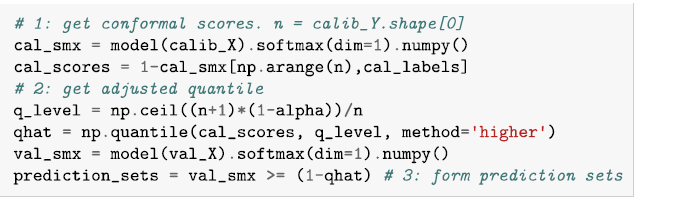

In [ ]:
import torch
import numpy as np
from tqdm import tqdm
import torch.nn.functional as F


def compute_nonconformity_scores(model, dataloader, device):
    model.eval()
    scores = []

    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc="Calibrating"):
            images, labels = images.to(device), labels.to(device)
            logits = model(images)
            probs = F.softmax(logits, dim=1)
            
            # Nonconformity = 1 - probability of the true class
            batch_scores = 1 - probs[torch.arange(len(labels)), labels]
            scores.extend(batch_scores.cpu().numpy())

    return np.array(scores)


def conformal_predict(model, dataloader, calib_scores, alpha, device):
    model.eval()
    prediction_sets = []
    true_labels = []

    #q_threshold = np.quantile(calib_scores, 1 - alpha)

     # Apply finite sample correction to the quantile level
    number_of_calibration_samples = len(calib_scores)
    #qlevel =         (1 - alpha) * ((number_of_calibration_samples + 1) / number_of_calibration_samples)
    qlevel = np.ceil((1 - alpha) * (number_of_calibration_samples + 1)) / number_of_calibration_samples

    
    #q_threshold = np.quantile(calib_scores, qlevel) # Use qlevel directly as it's already a percentile (0-1)
    q_threshold =  np.quantile(calib_scores, qlevel, interpolation="higher")


    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc="Testing"):
            images = images.to(device)
            logits = model(images)
            probs = F.softmax(logits, dim=1)

            for i in range(probs.shape[0]):
                # Prediction set = classes where 1 - prob <= qthreshold → prob >= 1 - qthreshold
                pred_set = torch.where(probs[i] >= (1 - q_threshold))[0].cpu().tolist()
                prediction_sets.append(pred_set)

            true_labels.extend(labels.cpu().tolist())

    return prediction_sets, true_labels


def evaluate_prediction_sets(prediction_sets, true_labels):
    correct = 0
    for pred_set, true_label in zip(prediction_sets, true_labels):
        if true_label in pred_set:
            correct += 1
    coverage = correct / len(true_labels)
    avg_set_size = np.mean([len(s) for s in prediction_sets])
    return coverage, avg_set_size


# Step 1: Load your model
#model.load_state_dict(torch.load("path_to_model.pth"))
#model.to(device)

# Step 2: Compute calibration scores
calib_scores = compute_nonconformity_scores(pretrained_vit, val_dataloader_pretrained, device)

# Step 3: Choose confidence level (e.g., 90%)
alpha = 0.1

# Step 4: Make predictions on test set
prediction_sets, true_labels = conformal_predict(pretrained_vit, test_dataloader_pretrained, calib_scores, alpha, device)

# Step 5: Evaluate
coverage, avg_size = evaluate_prediction_sets(prediction_sets, true_labels)

print(f"Conformal Prediction Results:")
print(f"  - Coverage: {coverage:.3f}")
print(f"  - Avg. Prediction Set Size: {avg_size:.2f}")


Testing: 100%|██████████| 2047/2047 [2:45:33<00:00,  4.85s/it]  

Conformal Prediction Results:
  - Coverage: 0.899
  - Avg. Prediction Set Size: 1.02


In [ ]:
import torch
import numpy as np
from tqdm import tqdm
import torch.nn.functional as F


def compute_nonconformity_scores(model, dataloader, device):
    model.eval()
    scores = []

    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc="Calibrating"):
            images, labels = images.to(device), labels.to(device)
            logits = model(images)
            probs = F.softmax(logits, dim=1)
            
            # Nonconformity = 1 - probability of the true class
            batch_scores = 1 - probs[torch.arange(len(labels)), labels]
            scores.extend(batch_scores.cpu().numpy())

    return np.array(scores)


def conformal_predict(model, dataloader, calib_scores, alpha, device):
    model.eval()
    prediction_sets = []
    true_labels = []

    #q_threshold = np.quantile(calib_scores, 1 - alpha)

     # Apply finite sample correction to the quantile level
    number_of_calibration_samples = len(calib_scores)
    #qlevel =         (1 - alpha) * ((number_of_calibration_samples + 1) / number_of_calibration_samples)
    qlevel = np.ceil((1 - alpha) * (number_of_calibration_samples + 1)) / number_of_calibration_samples

    
    #q_threshold = np.quantile(calib_scores, qlevel) # Use qlevel directly as it's already a percentile (0-1)
    q_threshold =  np.quantile(calib_scores, qlevel, interpolation="higher")


    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc="Testing"):
            images = images.to(device)
            logits = model(images)
            probs = F.softmax(logits, dim=1)

            for i in range(probs.shape[0]):
                # Prediction set = classes where 1 - prob <= qthreshold → prob >= 1 - qthreshold
                pred_set = torch.where(probs[i] >= (1 - q_threshold))[0].cpu().tolist()
                prediction_sets.append(pred_set)

            true_labels.extend(labels.cpu().tolist())

    return prediction_sets, true_labels


def evaluate_prediction_sets(prediction_sets, true_labels):
    correct = 0
    for pred_set, true_label in zip(prediction_sets, true_labels):
        if true_label in pred_set:
            correct += 1
    coverage = correct / len(true_labels)
    avg_set_size = np.mean([len(sets) for sets in prediction_sets])
    return coverage, avg_set_size


# Step 1: Load your model
#model.load_state_dict(torch.load("path_to_model.pth"))
#model.to(device)

# Step 2: Compute calibration scores
calib_scores = compute_nonconformity_scores(pretrained_vit, val_dataloader_pretrained, device)

# Step 3: Choose confidence level (e.g., 90%)
alpha = 0.1

# Step 4: Make predictions on test set
prediction_sets, true_labels = conformal_predict(pretrained_vit, test_dataloader_pretrained, calib_scores, alpha, device)

# Step 5: Evaluate
coverage, avg_size = evaluate_prediction_sets(prediction_sets, true_labels)

print(f"Conformal Prediction Results:")
print(f"  - Coverage: {coverage:.3f}")
print(f"  - Avg. Prediction Set Size: {avg_size:.2f}")


Calibrating:   3%|▎         | 52/2046 [04:30<2:41:51,  4.87s/it]

In [35]:
import torch
import numpy as np
from tqdm import tqdm
import torch.nn.functional as F


def compute_nonconformity_scores(model, dataloader, device):
    model.eval()
    scores = []
    i = 0 
    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc="Calibrating"):
            images, labels = images.to(device), labels.to(device)
            logits = model(images)
            #print(logits)
            probs = F.softmax(logits, dim=1)
            #print(probs)
            # Nonconformity = 1 - probability of the true class
            batch_scores = 1 - probs[torch.arange(len(labels)), labels]
            print(batch_scores)
            scores.extend(batch_scores.cpu().numpy())
            print(scores)
            if i == 3:
                break
            i = i + 1
    return np.array(scores)


calib_scores = compute_nonconformity_scores(pretrained_vit, val_dataloader_pretrained, device)

Calibrating:   0%|          | 1/2046 [00:33<18:47:01, 33.07s/it]

tensor([4.7946e-04, 1.0848e-05, 5.4836e-06, 3.2187e-06, 1.2875e-05, 7.0333e-06,
        2.0266e-06, 1.5855e-05, 4.2915e-06, 2.2650e-06, 1.1086e-05, 3.3379e-06,
        1.2720e-04, 9.9977e-01, 6.0797e-06, 9.2983e-06, 1.5855e-05, 6.7949e-06,
        1.2636e-05, 1.1146e-04, 1.3113e-06, 2.8849e-01, 8.5831e-06, 1.9908e-05,
        5.1022e-05, 9.9884e-01, 9.9983e-01, 6.7949e-06, 3.5763e-07, 9.3066e-01,
        7.3910e-06, 4.6492e-06])
[0.00047945976, 1.0848045e-05, 5.4836273e-06, 3.2186508e-06, 1.2874603e-05, 7.033348e-06, 2.026558e-06, 1.5854836e-05, 4.2915344e-06, 2.2649765e-06, 1.1086464e-05, 3.33786e-06, 0.00012719631, 0.99976593, 6.0796738e-06, 9.298325e-06, 1.5854836e-05, 6.7949295e-06, 1.2636185e-05, 0.000111460686, 1.3113022e-06, 0.2884916, 8.583069e-06, 1.9907951e-05, 5.1021576e-05, 0.9988442, 0.99982727, 6.7949295e-06, 3.5762787e-07, 0.9306628, 7.390976e-06, 4.6491623e-06]


Calibrating:   0%|          | 2/2046 [00:37<9:05:01, 16.00s/it] 

tensor([1.1921e-05, 3.4213e-05, 2.1458e-06, 8.3588e-01, 3.2187e-06, 1.7762e-05,
        3.8147e-06, 5.2214e-05, 4.9353e-05, 2.4756e-03, 1.0610e-05, 2.3246e-05,
        7.7486e-06, 2.3842e-06, 8.8453e-05, 1.2517e-05, 1.5497e-05, 7.7033e-04,
        1.5497e-05, 9.7017e-01, 5.7220e-06, 2.8610e-06, 1.9207e-01, 2.0266e-06,
        4.7684e-06, 1.0729e-06, 1.7881e-05, 9.9449e-01, 1.6570e-05, 7.2718e-06,
        4.6289e-04, 1.7285e-05])
[0.00047945976, 1.0848045e-05, 5.4836273e-06, 3.2186508e-06, 1.2874603e-05, 7.033348e-06, 2.026558e-06, 1.5854836e-05, 4.2915344e-06, 2.2649765e-06, 1.1086464e-05, 3.33786e-06, 0.00012719631, 0.99976593, 6.0796738e-06, 9.298325e-06, 1.5854836e-05, 6.7949295e-06, 1.2636185e-05, 0.000111460686, 1.3113022e-06, 0.2884916, 8.583069e-06, 1.9907951e-05, 5.1021576e-05, 0.9988442, 0.99982727, 6.7949295e-06, 3.5762787e-07, 0.9306628, 7.390976e-06, 4.6491623e-06, 1.1920929e-05, 3.4213066e-05, 2.1457672e-06, 0.8358775, 3.2186508e-06, 1.7762184e-05, 3.8146973e-06, 5.221367e

Calibrating:   0%|          | 3/2046 [00:41<5:56:54, 10.48s/it]

tensor([1.0169e-04, 7.9870e-06, 5.4836e-05, 5.8655e-03, 2.4199e-05, 3.9339e-06,
        1.4067e-05, 8.2254e-06, 1.1563e-05, 9.9996e-01, 4.0090e-01, 7.6294e-06,
        1.0490e-05, 4.7684e-06, 4.3154e-05, 2.2650e-06, 1.0014e-05, 2.3842e-07,
        7.8678e-06, 2.0266e-06, 3.2902e-05, 8.5147e-03, 8.7023e-06, 4.6492e-06,
        5.0306e-05, 2.3007e-05, 1.0462e-01, 4.7684e-06, 3.6657e-04, 7.2718e-06,
        4.5180e-05, 3.8147e-06])
[0.00047945976, 1.0848045e-05, 5.4836273e-06, 3.2186508e-06, 1.2874603e-05, 7.033348e-06, 2.026558e-06, 1.5854836e-05, 4.2915344e-06, 2.2649765e-06, 1.1086464e-05, 3.33786e-06, 0.00012719631, 0.99976593, 6.0796738e-06, 9.298325e-06, 1.5854836e-05, 6.7949295e-06, 1.2636185e-05, 0.000111460686, 1.3113022e-06, 0.2884916, 8.583069e-06, 1.9907951e-05, 5.1021576e-05, 0.9988442, 0.99982727, 6.7949295e-06, 3.5762787e-07, 0.9306628, 7.390976e-06, 4.6491623e-06, 1.1920929e-05, 3.4213066e-05, 2.1457672e-06, 0.8358775, 3.2186508e-06, 1.7762184e-05, 3.8146973e-06, 5.221367e

Calibrating:   0%|          | 3/2046 [00:46<8:42:11, 15.34s/it]


In [ ]:
def conformal_predict(model, dataloader, calib_scores, alpha, device):
    model.eval()
    prediction_sets = []
    true_labels = []

    #q_threshold = np.quantile(calib_scores, 1 - alpha)

     # Apply finite sample correction to the quantile level
    number_of_calibration_samples = len(calib_scores)
    #qlevel =         (1 - alpha) * ((number_of_calibration_samples + 1) / number_of_calibration_samples)
    qlevel = np.ceil((1 - alpha) * (number_of_calibration_samples + 1)) / number_of_calibration_samples

    
    #q_threshold = np.quantile(calib_scores, qlevel) # Use qlevel directly as it's already a percentile (0-1)
    q_threshold =  np.quantile(calib_scores, qlevel, interpolation="higher")


    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc="Testing"):
            images = images.to(device)
            logits = model(images)
            probs = F.softmax(logits, dim=1)

            for i in range(probs.shape[0]):
                # Prediction set = classes where 1 - prob <= qthreshold → prob >= 1 - qthreshold
                pred_set = torch.where(probs[i] >= (1 - q_threshold))[0].cpu().tolist()
                prediction_sets.append(pred_set)

            true_labels.extend(labels.cpu().tolist())

    return prediction_sets, true_labels


def evaluate_prediction_sets(prediction_sets, true_labels):
    correct = 0
    for pred_set, true_label in zip(prediction_sets, true_labels):
        if true_label in pred_set:
            correct += 1
    coverage = correct / len(true_labels)
    avg_set_size = np.mean([len(s) for s in prediction_sets])
    return coverage, avg_set_size


# Step 1: Load your model
#model.load_state_dict(torch.load("path_to_model.pth"))
#model.to(device)

# Step 2: Compute calibration scores
calib_scores = compute_nonconformity_scores(pretrained_vit, val_dataloader_pretrained, device)

# Step 3: Choose confidence level (e.g., 90%)
alpha = 0.1

# Step 4: Make predictions on test set
prediction_sets, true_labels = conformal_predict(pretrained_vit, test_dataloader_pretrained, calib_scores, alpha, device)

In [25]:
from torch import tensor

probs = tensor([[6.8709e-08, 4.2351e-08, 1.2112e-07, 6.8505e-07, 1.0000e+00, 7.0042e-08,
         2.2910e-08, 1.8036e-08, 1.1323e-08],
        [6.7193e-07, 1.2221e-07, 6.8735e-07, 9.9998e-01, 3.8082e-07, 1.8035e-05,
         6.2942e-07, 3.2710e-07, 4.7984e-07],
        [1.7658e-07, 9.0674e-07, 5.5080e-08, 3.2845e-06, 1.4192e-07, 4.2425e-06,
         4.4423e-07, 9.9999e-01, 7.4198e-07],
        [3.7963e-06, 1.3325e-06, 1.1986e-05, 9.9996e-01, 2.3790e-06, 9.9154e-07,
         2.3323e-06, 2.1640e-05, 2.4848e-07],
        [1.0980e-06, 1.3851e-07, 5.1018e-07, 1.0000e+00, 5.4728e-07, 5.1938e-07,
         3.8068e-07, 1.4570e-06, 1.1090e-07],
        [2.2604e-07, 3.8123e-08, 1.0206e-07, 1.7244e-07, 7.3436e-08, 1.2486e-07,
         1.7878e-08, 2.6392e-06, 1.0000e+00],
        [6.1236e-07, 1.0261e-06, 8.2183e-07, 9.9999e-01, 1.1760e-06, 3.1296e-06,
         1.8257e-06, 1.3217e-06, 1.4596e-07],
        [1.1490e-06, 5.2309e-06, 3.2716e-06, 9.9998e-01, 1.0567e-05, 1.3835e-06,
         1.1943e-06, 9.1565e-07, 1.0717e-07],
        [2.1558e-07, 7.1635e-07, 4.9147e-08, 6.7290e-07, 1.0000e+00, 2.1276e-07,
         1.4643e-07, 2.7387e-07, 1.5886e-07],
        [1.4793e-05, 6.3944e-07, 5.0585e-07, 1.3170e-06, 6.3901e-07, 9.9998e-01,
         8.9538e-07, 1.6281e-06, 1.1708e-06],
        [1.1026e-07, 1.6902e-08, 1.3941e-07, 3.1041e-07, 1.0000e+00, 1.0697e-07,
         4.2670e-08, 7.0726e-09, 2.1578e-07],
        [1.5851e-07, 2.4890e-07, 6.2480e-07, 1.0000e+00, 6.6868e-07, 1.1450e-06,
         4.1638e-07, 5.1002e-07, 1.0453e-07],
        [5.0993e-07, 5.2527e-07, 8.0983e-07, 1.0000e+00, 2.3271e-07, 1.1941e-06,
         5.3386e-07, 5.3900e-07, 1.5708e-07],
        [2.7827e-06, 5.6192e-07, 2.9106e-07, 9.9999e-01, 1.8997e-07, 1.0677e-06,
         1.0830e-06, 9.7273e-07, 2.9486e-07],
        [9.4970e-01, 2.1365e-05, 2.0029e-05, 7.5098e-05, 8.9124e-06, 4.2412e-02,
         3.6700e-05, 1.1299e-03, 6.5941e-03],
        [1.4344e-06, 3.3623e-07, 1.4869e-07, 1.2360e-06, 2.8590e-06, 9.9999e-01,
         1.0046e-06, 3.0356e-07, 1.1256e-06],
        [2.0695e-06, 1.7753e-06, 3.3843e-06, 3.6050e-04, 7.2572e-07, 9.9826e-01,
         4.9540e-05, 1.3243e-03, 6.2402e-07],
        [5.7377e-07, 6.8458e-07, 9.9946e-01, 1.5731e-04, 2.5690e-07, 3.6886e-04,
         7.4110e-07, 8.1294e-06, 1.1210e-06],
        [9.9305e-06, 1.4071e-07, 1.7751e-07, 3.2548e-06, 1.1736e-06, 9.9998e-01,
         4.4028e-07, 5.1738e-07, 6.4045e-08],
        [3.5548e-04, 6.4539e-07, 2.1702e-06, 9.1601e-01, 3.6517e-05, 1.0209e-03,
         1.2837e-05, 1.5881e-04, 8.2401e-02],
        [1.8818e-06, 2.3329e-06, 9.3004e-07, 1.7614e-06, 4.2815e-07, 1.3229e-05,
         1.4555e-05, 9.9996e-01, 8.5313e-07],
        [8.7667e-07, 9.5353e-07, 3.1144e-06, 9.9928e-01, 7.1372e-07, 7.0792e-04,
         1.2871e-06, 7.4206e-06, 2.4123e-07],
        [1.6697e-07, 1.1383e-07, 9.2113e-08, 5.4342e-07, 1.0000e+00, 2.7918e-08,
         1.4185e-07, 1.3478e-07, 1.4846e-08],
        [3.1294e-06, 4.0982e-07, 1.2234e-06, 9.9998e-01, 1.7090e-06, 4.9379e-06,
         1.7861e-06, 3.3276e-06, 1.5979e-06],
        [4.6791e-05, 7.8141e-06, 3.7183e-05, 9.0011e-01, 1.3935e-06, 8.1496e-02,
         2.0576e-05, 1.8025e-02, 2.5535e-04],
        [1.2839e-07, 3.1351e-07, 1.1039e-06, 3.8231e-07, 1.0000e+00, 9.8887e-08,
         9.2726e-08, 4.5573e-08, 5.0211e-08],
        [1.3837e-07, 2.2378e-07, 3.0250e-07, 6.5579e-07, 1.0000e+00, 8.4995e-08,
         4.8761e-08, 3.9466e-08, 6.9660e-07],
        [2.8623e-06, 3.7181e-07, 2.2368e-07, 2.2280e-04, 1.0319e-06, 2.2255e-06,
         7.2536e-07, 2.3705e-07, 9.9977e-01],
        [1.6225e-05, 2.6943e-06, 6.5512e-07, 9.9989e-01, 1.2256e-06, 8.5345e-05,
         3.8037e-06, 3.3679e-06, 2.6572e-07],
        [7.3648e-06, 1.0283e-06, 3.6701e-06, 9.9984e-01, 1.1412e-04, 1.4009e-05,
         6.3348e-06, 1.1067e-05, 3.4393e-06],
        [1.7725e-06, 3.8951e-07, 2.9109e-06, 9.9999e-01, 3.9279e-06, 1.0808e-06,
         6.9467e-07, 1.0790e-06, 8.2957e-08],
        [3.2619e-05, 3.4069e-06, 1.4480e-05, 1.9212e-03, 6.3451e-07, 9.9800e-01,
         3.8464e-06, 1.0359e-05, 1.5819e-05]])

In [27]:
label = []
for images, labels in tqdm(val_dataloader_pretrained, desc="Calibrating"):
    label = labels
    break
label

Calibrating:   0%|          | 0/2046 [00:30<?, ?it/s]


tensor([5, 5, 6, 5, 0, 5, 5, 5, 8, 4, 0, 6, 6, 7, 7, 5, 5, 5, 7, 5, 2, 5, 4, 8,
        5, 6, 3, 5, 4, 5, 3, 5])

In [28]:
len(labels)

32

In [29]:
probs[torch.arange(len(labels)), labels]

tensor([7.0042e-08, 1.8035e-05, 4.4423e-07, 9.9154e-07, 1.0980e-06, 1.2486e-07,
        3.1296e-06, 1.3835e-06, 1.5886e-07, 6.3901e-07, 1.1026e-07, 4.1638e-07,
        5.3386e-07, 9.7273e-07, 1.1299e-03, 9.9999e-01, 9.9826e-01, 3.6886e-04,
        5.1738e-07, 1.0209e-03, 9.3004e-07, 7.0792e-04, 1.0000e+00, 1.5979e-06,
        8.1496e-02, 9.2726e-08, 6.5579e-07, 2.2255e-06, 1.2256e-06, 1.4009e-05,
        9.9999e-01, 9.9800e-01])

In [32]:
#probs[torch.arange(len(labels)), labels] = tensor([0.7, 0.6])
batch_scores = 1 - probs[torch.arange(len(labels)), labels]
batch_scores

tensor([1.0000e+00, 9.9998e-01, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
        1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
        1.0000e+00, 1.0000e+00, 9.9887e-01, 1.0014e-05, 1.7400e-03, 9.9963e-01,
        1.0000e+00, 9.9898e-01, 1.0000e+00, 9.9929e-01, 0.0000e+00, 1.0000e+00,
        9.1850e-01, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 9.9999e-01,
        1.0014e-05, 2.0000e-03])

In [ ]:
probs[torch.arange(2), labels] = tensor([0.7, 0.6])
batch_scores = 1 - tensor([0.7, 0.6]) = tensor([0.3, 0.4])


In [33]:
scores = []
scores.extend(batch_scores.cpu().numpy())
scores

[0.99999994,
 0.99998194,
 0.9999996,
 0.999999,
 0.9999989,
 0.9999999,
 0.99999684,
 0.9999986,
 0.9999998,
 0.99999934,
 0.9999999,
 0.9999996,
 0.99999946,
 0.99999905,
 0.9988701,
 1.001358e-05,
 0.0017399788,
 0.99963117,
 0.99999946,
 0.9989791,
 0.99999905,
 0.9992921,
 0.0,
 0.9999984,
 0.918504,
 0.9999999,
 0.99999934,
 0.9999978,
 0.99999875,
 0.999986,
 1.001358e-05,
 0.0019999743]

In [ ]:
def compute_nonconformity_scores(model, dataloader, device):
    model.eval()
    scores = []
    i = 0 
    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc="Calibrating"):
            images, labels = images.to(device), labels.to(device)
            logits = model(images)
            print(logits)
            probs = F.softmax(logits, dim=1)
            print(probs)
            # Nonconformity = 1 - probability of the true class
            batch_scores = 1 - probs[torch.arange(len(labels)), labels]
            print(batch_scores)
            scores.extend(batch_scores.cpu().numpy())
            print(scores)
            #if i == 3:
            break
            #i = i + 1
    return np.array(scores)

In [43]:
import torch
import numpy as np
from tqdm import tqdm
import torch.nn.functional as F


def compute_nonconformity_scores(model, dataloader, device):
    model.eval()
    scores = []

    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc="Calibrating"):
            images, labels = images.to(device), labels.to(device)
            logits = model(images)
            probs = F.softmax(logits, dim=1)
            
            # Nonconformity = 1 - probability of the true class
            batch_scores = 1 - probs[torch.arange(len(labels)), labels]
            scores.extend(batch_scores.cpu().numpy())
            break
    return np.array(scores)


def conformal_predict(model, dataloader, calib_scores, alpha, device):
    model.eval()
    prediction_sets = []
    true_labels = []

    #q_threshold = np.quantile(calib_scores, 1 - alpha)

     # Apply finite sample correction to the quantile level
    number_of_calibration_samples = len(calib_scores)
    print("Number of calibration samples: ", number_of_calibration_samples)
    #qlevel =         (1 - alpha) * ((number_of_calibration_samples + 1) / number_of_calibration_samples)
    qlevel = np.ceil((1 - alpha) * (number_of_calibration_samples + 1)) / number_of_calibration_samples
    print("qlevel of samples: ", qlevel)
    #q_threshold = np.quantile(calib_scores, qlevel) # Use qlevel directly as it's already a percentile (0-1)
    q_threshold =  np.quantile(calib_scores, qlevel, interpolation="higher")
    print("q threshold of samples: ", q_threshold)

    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc="Testing"):
            images = images.to(device)
            logits = model(images)
            print("logits : ", logits)
            probs = F.softmax(logits, dim=1)
            print("probabilities : ",probs)
            print("probabilities shape : ", (probs.shape[0]))
            for i in range(probs.shape[0]):
                # Prediction set = classes where 1 - prob <= qthreshold → prob >= 1 - qthreshold
                print(" torch.where torch.where(probs[i] >= (1 - q_threshold)): ", torch.where(probs[i] >= (1 - q_threshold)))
                print(" torch.where torch.where(probs[i] >= (1 - q_threshold))[0]: ", torch.where(probs[i] >= (1 - q_threshold))[0])
                pred_set = torch.where(probs[i] >= (1 - q_threshold))[0].cpu().tolist()
                print("Single prediction set for a batch : ", pred_set)
                prediction_sets.append(pred_set)
                print("Prediction sets : ", prediction_sets)
            true_labels.extend(labels.cpu().tolist())
            print(true_labels)
            break
    return prediction_sets, true_labels


# Step 1: Load your model
#model.load_state_dict(torch.load("path_to_model.pth"))
#model.to(device)

# Step 2: Compute calibration scores
calib_scores = compute_nonconformity_scores(pretrained_vit, val_dataloader_pretrained, device)

# Step 3: Choose confidence level (e.g., 90%)
alpha = 0.1

# Step 4: Make predictions on test set
prediction_sets, true_labels = conformal_predict(pretrained_vit, test_dataloader_pretrained, calib_scores, alpha, device)

# Step 5: Evaluate
#coverage, avg_size = evaluate_prediction_sets(prediction_sets, true_labels)

#print(f"Conformal Prediction Results:")
#print(f"  - Coverage: {coverage:.3f}")
#print(f"  - Avg. Prediction Set Size: {avg_size:.2f}")


Calibrating:   0%|          | 0/2046 [00:34<?, ?it/s]
C:\Users\alita\AppData\Local\Temp\ipykernel_10888\380311795.py:74: DeprecationWarning: the `interpolation=` argument to quantile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  prediction_sets, true_labels = conformal_predict(pretrained_vit, test_dataloader_pretrained, calib_scores, alpha, device)


Number of calibration samples:  32
qlevel of samples:  0.9375
q threshold of samples:  0.09103668


Testing:   0%|          | 0/2047 [00:00<?, ?it/s]

logits :  tensor([[ 5.9199e+00, -2.7402e+00, -4.1140e+00,  8.2474e+00,  1.1109e+00,
         -3.0968e+00, -3.4346e+00, -2.2069e+00, -3.8494e+00],
        [ 7.7791e+00, -5.0009e+00, -3.3917e+00,  4.7646e+00,  2.0988e+00,
         -1.9518e+00, -4.0907e+00, -1.4292e+00, -4.3785e+00],
        [ 7.5201e+00, -2.7193e+00, -4.9081e+00,  7.3716e+00, -5.7079e-01,
         -3.5404e+00, -3.7196e+00, -1.2865e+00, -2.5679e+00],
        [ 1.5246e+01, -1.6633e+00, -2.6756e+00, -1.2675e+00, -7.3678e-01,
         -1.2178e+00, -1.6864e+00, -1.0405e+00, -2.6251e+00],
        [ 1.5176e+01, -9.1834e-01, -2.5375e+00,  1.5291e-01, -1.1559e+00,
         -3.4724e+00, -1.4233e+00,  8.7237e-02, -3.0716e+00],
        [ 1.5545e+01, -1.5590e+00, -2.4437e+00, -5.2961e-01, -1.2884e+00,
         -2.3407e+00, -1.6094e+00, -9.4047e-01, -2.3884e+00],
        [ 1.4938e+01, -3.1650e+00, -3.7853e+00,  3.1453e-01, -1.7199e+00,
         -1.0008e+00, -1.2574e+00, -8.4869e-01, -2.5367e+00],
        [ 1.4797e+01, -1.1838e+00, -2.

Testing:   0%|          | 0/2047 [00:34<?, ?it/s]


In [ ]:
import torch
import numpy as np
from tqdm import tqdm
import torch.nn.functional as F


def compute_nonconformity_scores(model, dataloader, device):
    model.eval()
    scores = []

    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc="Calibrating"):
            images, labels = images.to(device), labels.to(device)
            logits = model(images)
            probs = F.softmax(logits, dim=1)
            
            # Nonconformity = 1 - probability of the true class
            batch_scores = 1 - probs[torch.arange(len(labels)), labels]
            scores.extend(batch_scores.cpu().numpy())

    return np.array(scores)


def conformal_predict(model, dataloader, calib_scores, alpha, device):
    model.eval()
    prediction_sets = []
    true_labels = []

    #q_threshold = np.quantile(calib_scores, 1 - alpha)

     # Apply finite sample correction to the quantile level
    number_of_calibration_samples = len(calib_scores)
    #qlevel =         (1 - alpha) * ((number_of_calibration_samples + 1) / number_of_calibration_samples)
    qlevel = np.ceil((1 - alpha) * (number_of_calibration_samples + 1)) / number_of_calibration_samples

    
    #q_threshold = np.quantile(calib_scores, qlevel) # Use qlevel directly as it's already a percentile (0-1)
    q_threshold =  np.quantile(calib_scores, qlevel, interpolation="higher")


    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc="Testing"):
            images = images.to(device)
            logits = model(images)
            probs = F.softmax(logits, dim=1)

            for i in range(probs.shape[0]):
                # Prediction set = classes where 1 - prob <= qthreshold → prob >= 1 - qthreshold
                pred_set = torch.where(probs[i] >= (1 - q_threshold))[0].cpu().tolist()
                prediction_sets.append(pred_set)

            true_labels.extend(labels.cpu().tolist())

    return prediction_sets, true_labels


def evaluate_prediction_sets(prediction_sets, true_labels):
    correct = 0
    for pred_set, true_label in zip(prediction_sets, true_labels):
        if true_label in pred_set:
            correct += 1
    coverage = correct / len(true_labels)
    avg_set_size = np.mean([len(set) for set in prediction_sets])
    return coverage, avg_set_size


# Step 1: Load your model
#model.load_state_dict(torch.load("path_to_model.pth"))
#model.to(device)

# Step 2: Compute calibration scores
calib_scores = compute_nonconformity_scores(pretrained_vit, val_dataloader_pretrained, device)

# Step 3: Choose confidence level (e.g., 90%)
alpha = 0.1

# Step 4: Make predictions on test set
prediction_sets, true_labels = conformal_predict(pretrained_vit, test_dataloader_pretrained, calib_scores, alpha, device)

# Step 5: Evaluate
coverage, avg_size = evaluate_prediction_sets(prediction_sets, true_labels)

print(f"Conformal Prediction Results:")
print(f"  - Coverage: {coverage:.3f}")
print(f"  - Avg. Prediction Set Size: {avg_size:.2f}")
